In [1]:
from matplotlib import pyplot as plt
import numpy as np
import lmfit
import xarray as xr
import dask.array as da
import os

from bio_optics.models import model_dask as model
from bio_optics.helper import resampling
from bio_optics.atmosphere import downwelling_irradiance

### Get data

This is a fun Sentinel-2 dataset from the intertidal of the Wadden Sea. The first image shows a seagrass meadow at low tide, the second image shows the same meadow submerged at high tide. Here, we assume that the first image is a perfect representation of the benthic albedo in the second image and use it as an input for the inversion. Both images were atmospherically corrected using Sen2Cor.

In [3]:
dataset = xr.open_dataset(('/').join([os.getcwd(), 'example_data/S2L2A_example.nc']))

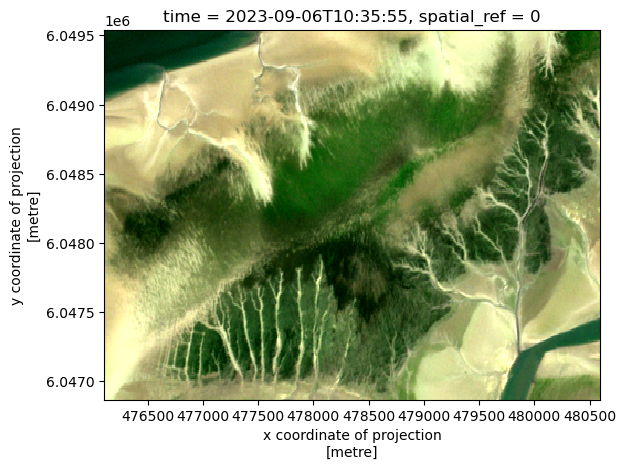

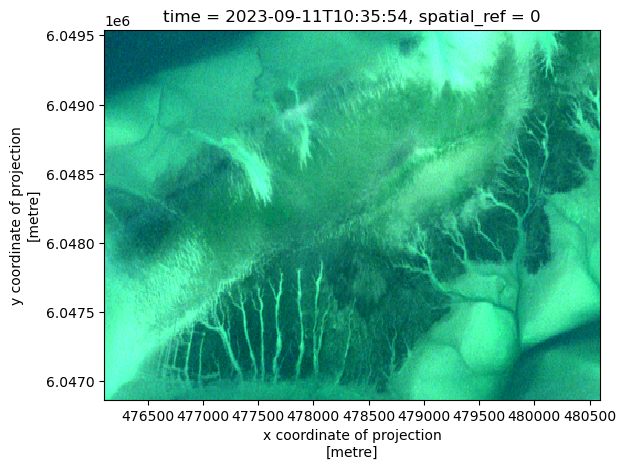

In [4]:
# plot pseudo true-color RGB
dataset[['B04','B03','B02']].isel(time=0).to_array().plot.imshow(robust=True)
plt.show()

dataset[['B04','B03','B02']].isel(time=1).to_array().plot.imshow(robust=True)
plt.show()

In [5]:
# prep cubes and make sure they both have the same chunking
cube1 = da.stack([dataset.isel(time=1)[var].data for var in dataset.isel(time=1).data_vars][1:]) / np.pi
cube1 = cube1.rechunk(chunks=(cube1.shape[0],32,32))

cube2 = da.stack([dataset.isel(time=0)[var].data for var in dataset.isel(time=0).data_vars][1:]) 
cube2 = cube2.rechunk(chunks=(cube2.shape[0],32,32))

In [6]:
# S2 wavelengths for this dataset
wavelengths = np.array([490, 560, 665, 705, 740, 783, 842, 865])

### Resample LUTs

In [7]:
a_i_spec_res = resampling.resample_a_i_spec(wavelengths)
a_w_res = resampling.resample_a_w(wavelengths)
b_phy_norm_res = resampling.resample_b_phy_norm(wavelengths)
b_bw_res = resampling.resample_b_bw(wavelengths)
E_0_res = resampling.resample_E_0(wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths)
n2_res = resampling.resample_n(wavelengths)

E_dd_res = downwelling_irradiance.E_dd(wavelengths)
E_dsa_res = downwelling_irradiance.E_dsa(wavelengths)
E_dsr_res = downwelling_irradiance.E_dsr(wavelengths)
E_d_res = E_dd_res + E_dsa_res + E_dsr_res

R_i_b_res = resampling.resample_R_i_b(wavelengths)

### Create params

In [8]:
# create lmfit.Parameters() object, define min, max and start values and define which parms to fit

params = lmfit.Parameters()
params.add('C_0', value=0, min=1e-10, max=1, vary=False)
params.add('C_1', value=0, min=0, max=100, vary=False)
params.add('C_2', value=0, min=0, max=100, vary=False)
params.add('C_3', value=0, min=0, max=100, vary=False)
params.add('C_4', value=0, min=0, max=100, vary=False)
params.add('C_5', value=0, min=0, max=100, vary=False)
params.add('C_Y', value=0, min=0, max=1, vary=False)
params.add('C_X', value=0, min=0.0, max=1, vary=False)
params.add('C_Mie', value=0, min=0.0, max=1, vary=False)
params.add('f_0', value=1, min=0, max=1, vary=False)
params.add('f_1', value=0, min=0, max=1, vary=False)
params.add('f_2', value=0, min=0, max=1, vary=False)
params.add('f_3', value=0, min=0, max=1, vary=False)
params.add('f_4', value=0, min=0, max=1, vary=False)
params.add('f_5', value=0, min=0, max=1, vary=False)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('b_bphy_spec', value=0.0010, vary=False)
params.add('b_bMie_spec', value=0.0042, vary=False)
params.add('b_bX_spec', value=0.0086, min=0, max=1, vary=False)
params.add('b_bX_norm_factor', value=1, vary=False)
params.add('a_NAP_spec_lambda_0', value=0.041, min=0.01, max=0.12, vary=False) 
params.add('S', value=0.014, min=0.007, max=0.026, vary=False) 
params.add('K', value=0, min=0, vary=False)
params.add('S_NAP', value=0.011, vary=False)
params.add('n', value=-1, min=-1, max=0, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=500, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(1e-10), min=np.radians(0), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('zB', value=2, min=0, max=5, vary=True)
params.add('T_W', value=18, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('error_method', value=0, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=False) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
# params.add('rho_L', value=0.02006, vary=False) # rho_L is an optional parameter, if it is provided through the params object it will be used. if not, it will be computed using the Frensel equation.
params.add('offset', value=0, min=0, max=0.01, vary=False)
params.add('fit_surface', value=False, vary=False)

### Define spectral weights

In [9]:
# define weights for each band
weights = np.ones(len(wavelengths))

### Wrap invert function for dask

In [10]:
def invert_dask(cube1, # this is remote sensing reflectance (R_rs)
                cube2, # this is benthic reflectance (R_i_b)
                params=None, # this is a str generated using params.dumps()
                wavelengths=None,
                weights=None,
                a_i_spec_res=None,
                a_w_res=None,
                b_phy_norm_res=None,
                b_bw_res=None,
                R_i_b_res=None,
                E_0_res=None,
                a_oz_res=None,
                a_ox_res=None,
                a_wv_res=None,
                da_W_div_dT_res=None,
                E_d_res=None,
                E_dsa_res=None,
                E_dsr_res=None,
                E_dd_res=None,
                n2_res=None,
                method="least_squares", 
                max_nfev=400):
    
    # reshape from 3D to 2D to only have one for-loop
    R_rs =  np.reshape(cube1, (cube1.shape[0], -1))
    R_i_b = np.reshape(cube2, (cube2.shape[0], -1))
    
    # make a copy of actual params str to make it mutable
    chunk_params = params # here, params is already a str, so assigning it makes a copy internally  
    # automatically construct list of varying_params from params by rebuilding the lmfit.Parameters() object to make sure results has the right size 
    # !!! this is ugly and there must be a more elegant solution! 
    # !!! this solution will also always return arrays for the g_di params as vary will always be true for them (activation via value of fit_surface) ...
    paramters = lmfit.Parameters().loads(params)
    varying_params = [key for key in paramters.keys() if paramters[key].vary or paramters[key].expr]
    
    # initialize results array
    results = np.zeros((len(varying_params), R_rs.shape[1]))
    
    # invert spectrum-wise
    for i in range(R_rs.shape[1]):

        # get R_rs spectrum
        R_rs_i = R_rs[:, i]
        # get benthic reflectance
        R_i_b_res = R_i_b_res.copy() # make a copy of R_i_b_res to make it mutable
        R_i_b_res[:,0] = R_i_b[:, i] # assign spectrum from 2nd image to first element in R_i_b_res

        # test if any input contains nans
        if np.isnan(R_rs_i).any() or np.isnan(R_i_b_res).any():
            results[:,i] = np.nan
            continue
        
        result = model.invert(chunk_params, 
                              R_rs = R_rs_i, 
                              wavelengths = wavelengths, 
                              weights = weights,
                              a_i_spec_res = a_i_spec_res,
                              a_w_res = a_w_res,
                              b_phy_norm_res = b_phy_norm_res,
                              b_bw_res = b_bw_res,
                              R_i_b_res = R_i_b_res,
                              E_0_res = E_0_res,
                              a_oz_res = a_oz_res,
                              a_ox_res = a_ox_res,
                              a_wv_res = a_wv_res,
                              da_W_div_dT_res = da_W_div_dT_res,
                              E_d_res = E_d_res,
                              E_dsa_res = E_dsa_res,
                              E_dsr_res = E_dsr_res,
                              E_dd_res = E_dd_res,
                              n2_res = n2_res,
                              method = method, 
                              max_nfev = max_nfev)

        # fill results array
        results[:,i] = np.array([param.value for name, param in result.params.items() if param.vary])           
        
    return results.reshape((len(varying_params), cube1.shape[1], cube1.shape[2]))

## Run inversion

In [11]:
graph = da.map_blocks(invert_dask, 
                      cube1, 
                      cube2,
                      meta=np.array((), dtype=np.float32),
                      dtype=np.float32,
                      params=params.dumps(), # dump params (convert to str) to make it serializable 
                      wavelengths=wavelengths,
                      weights=weights,
                      a_i_spec_res=a_i_spec_res,
                      a_w_res=a_w_res,
                      b_phy_norm_res=b_phy_norm_res,
                      b_bw_res=b_bw_res,
                      R_i_b_res=R_i_b_res,
                      E_0_res=E_0_res,
                      a_oz_res=a_oz_res,
                      a_ox_res=a_ox_res,
                      a_wv_res=a_wv_res,
                      da_W_div_dT_res=da_W_div_dT_res,
                      E_d_res=E_d_res,
                      E_dsa_res=E_dsa_res,
                      E_dsr_res=E_dsr_res,
                      E_dd_res=E_dd_res,
                      n2_res=n2_res,
                      method="least_squares", 
                      max_nfev=400,
                      )

result = graph.compute(scheduler='processes')

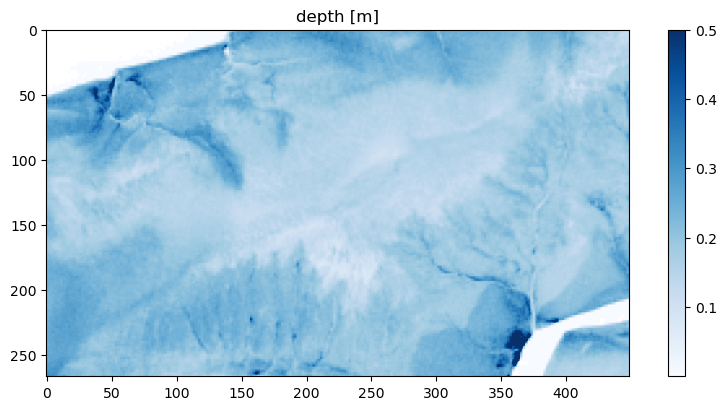

In [12]:
plt.figure(figsize=(10,4.5))
plt.imshow(result[0], cmap='Blues', vmax=0.5)
plt.title('depth [m]')
plt.colorbar()
plt.show()